# Article Text Summarization

## NLTK Approach

In [2]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# The low end of shared words to consider
LOWER_BOUND = .20

# The high end, since anything above this is probably SEO garbage or a
# duplicate sentence
UPPER_BOUND = .90

def is_unimportant(word):
    """Decides if a word is ok to toss out for the sentence comparisons"""
    return word in ['.', '!', ',', ] or '\'' in word or word in stop_words

def only_important(sent):
    """Just a little wrapper to filter on is_unimportant"""
    return filter(lambda w: not is_unimportant(w), sent)

def compare_sents(sent1, sent2):
    """Compare two word-tokenized sentences for shared words"""
    if not len(sent1) or not len(sent2):
        return 0
    return len(set(only_important(sent1)) & set(only_important(sent2))) / ((len(sent1) + len(sent2)) / 2.0)

def compare_sents_bounded(sent1, sent2):
    """If the result of compare_sents is not between LOWER_BOUND and
    UPPER_BOUND, it returns 0 instead, so outliers don't mess with the sum"""
    cmpd = compare_sents(sent1, sent2)
    if LOWER_BOUND < cmpd < UPPER_BOUND:
        return cmpd
    else:
        return 0

def compute_score(sent, sents):
    """Computes the average score of sent vs the other sentences (the result of
    sent vs itself isn't counted because it's 1, and that's above
    UPPER_BOUND)"""
    if not len(sent):
        return 0
    return sum(compare_sents_bounded(sent, sent1) for sent1 in sents) / float(len(sents))

def summarize(block):
    """Return the sentence that best summarizes block"""
    if not block:
        return None
    sents = nltk.sent_tokenize(block)
    word_sents = list(map(nltk.word_tokenize, sents))
    d = dict((compute_score(word_sent, word_sents), sent)
             for sent, word_sent in zip(sents, word_sents))
    return d[max(d.keys())]

In [3]:
article = """
Taking vitamin C orally along with conventional antihypertensive medications appears to modestly decrease systolic blood pressure, but the effects on diastolic pressure are mixed . In patients with type 2 diabetes, taking vitamin C 500 mg daily for 4 weeks, in addition to antihypertensives, seems to reduce arterial blood pressure and decrease arterial stiffness . However, taking supplemental vitamin C 500 mg daily without antihypertensives does not seem to reduce systolic or diastolic blood pressure . Dietary restriction of vitamin C is associated with increases in both diastolic and systolic blood pressure (10354
"""
summarize(article)

'However, taking supplemental vitamin C 500 mg daily without antihypertensives does not seem to reduce systolic or diastolic blood pressure .'

## ML Approach

### Getting the Text ready

In [4]:
from neo4j.v1 import GraphDatabase, basic_auth

driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "naturalmed"))
session = driver.session()

In [142]:
query = session.run("MATCH (m:Medicine)-[r1]->(n:DiseaseInteraction)-[r2]->(d:Disease) \
                     RETURN m.name, n.text, d.id")

data = [(r['m.name'], r['n.text'], r['d.id'], summarize(r['n.text'])) for r in query]

infos = [e[1] for e in data]
summaries = [e[3] for e in data]

In [143]:
infos[1]

'Constituents isolated from Acacia rigidula are thought to have stimulant effects . Additionally, dietary supplements listing Acacia rigidula as an ingredient have been shown to contain the stimulant beta-methylphenethylamine (BMPEA) and greater amounts of other stimulant compounds than would normally be found in plant parts . BMPEA has been shown to increase blood pressure and heart rate in animals . Theoretically, taking Acacia rigidula supplements might exacerbate high blood pressure.'

In [144]:
summaries[1]

'Theoretically, taking Acacia rigidula supplements might exacerbate high blood pressure.'

In [145]:
print(len(infos))
print(len(summaries))

2336
2336


In [172]:
def get_vocab(lst):
    """ Returns the vocab and count of each word in a list of strings
    """
    d = Counter(w.lower() for txt in lst for w in txt.split())
    return list(d.keys()), list(d.values())

In [173]:
vocab, count = get_vocab(infos)

In [175]:
vocab[:7]

['acacia', 'can', 'cause', 'reactions', 'in', 'individuals', 'allergic']

In [176]:
print(len(vocab))
print(len(count))

4657
4657


In [177]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos + 1 # first real word

In [178]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [179]:
word2idx, idx2word = get_idx(vocab, count)

### Loading and formating the GloVe lists

In [180]:
embedding_dim = 50

In [181]:
glove_path ='./../Datasets/glove.6B/glove.6B.%sd.txt' % embedding_dim

In [182]:
glove_n_symbols = !wc -l {glove_path}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [183]:
import numpy as np

In [184]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale = 0.1

with open(glove_path, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = [float(e) for e in l[1:]]
        i += 1

glove_embedding_weights *= globale_scale

In [185]:
print(glove_embedding_weights)

[[ 0.0418     0.024968  -0.041242  ..., -0.018411  -0.011514  -0.078581 ]
 [ 0.0013441  0.023682  -0.016899  ..., -0.056657   0.0044691  0.030392 ]
 [ 0.015164   0.030177  -0.016763  ..., -0.035652   0.0016413  0.010216 ]
 ..., 
 [-0.051181   0.0058706  0.10913   ..., -0.025003  -0.1125     0.15863  ]
 [-0.075898  -0.047426   0.04737   ...,  0.078954  -0.0014116  0.06448  ]
 [ 0.0072617 -0.051393   0.04728   ..., -0.018907  -0.059021   0.055559 ]]


In [186]:
glove_embedding_weights.std()

0.064410429768131147

In [187]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [188]:
seed = 42
vocab_size = len(vocab)

np.random.seed(seed)

shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std() * np.sqrt(12) / 2
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

c = 0
for i in range(len(vocab)):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1

In [189]:
len(embedding)

4657

In [190]:
vocab_size

4657

In [191]:
glove_thr = 0.5

In [192]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [193]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('{} of glove substitutes found'.format(len(glove_match)))

66 of glove substitutes found


In [194]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.610201867614 dock => harbor
0.582583655227 mate => younger
0.574584160008 habitually => habitual
0.571254292226 wahoo => pud
0.558218106953 ra => haw
0.556304544124 enlargement => brussels
0.532109899224 wallflower => dendrobium
0.52087705412 mansa => terminalia
0.51769653988 yerba => breadfruit
0.502346659661 yarrow => wort


In [195]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

### Looking at the results

In [205]:
Y = [[word2idx[token.lower()] for token in summary.split()] for summary in summaries]
len(Y)

2336

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([   9.,  257.,   10.,   26.,   49.,  112.,  131.,  141.,  152.,
         167.,  127.,  129.,  140.,  182.,  118.,   98.,    0.,   92.,
          62.,   52.,   39.,   37.,   35.,   35.,   27.,   21.,   12.,
          16.,    9.,   11.,    9.,    4.,    2.,    0.,    3.,    3.,
           1.,    0.,    1.,    3.,    1.,    0.,    3.,    1.,    1.,
           2.,    0.,    0.,    3.,    3.]),
 array([  1.  ,   1.94,   2.88,   3.82,   4.76,   5.7 ,   6.64,   7.58,
          8.52,   9.46,  10.4 ,  11.34,  12.28,  13.22,  14.16,  15.1 ,
         16.04,  16.98,  17.92,  18.86,  19.8 ,  20.74,  21.68,  22.62,
         23.56,  24.5 ,  25.44,  26.38,  27.32,  28.26,  29.2 ,  30.14,
         31.08,  32.02,  32.96,  33.9 ,  34.84,  35.78,  36.72,  37.66,
         38.6 ,  39.54,  40.48,  41.42,  42.36,  43.3 ,  44.24,  45.18,
         46.12,  47.06,  48.  ]),
 <a list of 50 Patch objects>)

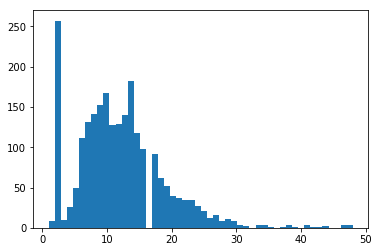

In [207]:
plt.hist([len(y) for y in Y], bins=50)

In [208]:
X = [[word2idx[token.lower()] for token in info.split()] for info in infos]
len(X)

2336

(array([ 266.,   53.,  161.,  150.,  168.,  168.,  144.,  180.,  155.,
         123.,  197.,  116.,   85.,   70.,   48.,   41.,   44.,   25.,
          18.,   14.,   18.,   11.,    5.,    6.,    9.,    2.,   13.,
           1.,    8.,    3.,    5.,    3.,    1.,    1.,    1.,    3.,
           1.,    0.,    1.,    4.,    4.,    0.,    0.,    2.,    2.,
           1.,    2.,    1.,    1.,    1.]),
 array([   1. ,    4.1,    7.2,   10.3,   13.4,   16.5,   19.6,   22.7,
          25.8,   28.9,   32. ,   35.1,   38.2,   41.3,   44.4,   47.5,
          50.6,   53.7,   56.8,   59.9,   63. ,   66.1,   69.2,   72.3,
          75.4,   78.5,   81.6,   84.7,   87.8,   90.9,   94. ,   97.1,
         100.2,  103.3,  106.4,  109.5,  112.6,  115.7,  118.8,  121.9,
         125. ,  128.1,  131.2,  134.3,  137.4,  140.5,  143.6,  146.7,
         149.8,  152.9,  156. ]),
 <a list of 50 Patch objects>)

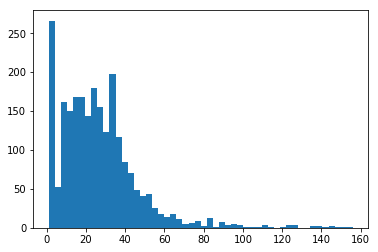

In [209]:
plt.hist([len(x) for x in X], bins=50)

### Dumping the objects to the disk

In [211]:
import pickle

FN = 'vocabulary-embedding'

with open('./../Dumps/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

with open('./../Dumps/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)

### Starting building the model

In [215]:
import keras

In [213]:
maxlend = 25 # 0 - if we dont want to use description at all
maxlenh = 25
maxlen = maxlend + maxlenh
rnn_size = 512 # must be same as 160330-word-gen
rnn_layers = 3  # match FN1
batch_norm = False

In [214]:
activation_rnn_size = 40 if maxlend else 0

In [256]:
# training parameters
seed = 42
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
LR = 1e-4
batch_size = 64
nflips = 10

In [226]:
nb_train_samples = 1500
nb_val_samples = 500

### Loading the embedding

In [219]:
with open('./../Dumps/%s.pkl'%FN, 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

with open('./../Dumps/%s.data.pkl'%FN, 'rb') as fp:
    X, Y = pickle.load(fp)

In [220]:
nb_unknown_words = 10

In [221]:
print('number of examples',len(X),len(Y))
print('dimension of embedding space for words',embedding_size)
print('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print('total number of different words',len(idx2word), len(word2idx))
print('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

number of examples 2336 2336
dimension of embedding space for words 50
vocabulary size 4657 the last 10 words can be used as place holders for unknown/oov words
total number of different words 4659 4659
number of words outside vocabulary which we can substitue using glove similarity 66
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) -64


In [222]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [223]:
oov0 = vocab_size-nb_unknown_words

In [224]:
for i in range(oov0, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [227]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1836, 1836, 500, 500)

In [228]:
del X
del Y

In [229]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [230]:
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [240]:
def prt(label, x):
    print(label+':')
    s = ""
    for w in x:
        s += " " + idx2word[w]
    print(s)

In [249]:
i = 3
prt('H',Y_train[i])
prt('D',X_train[i])

H:
 animal research suggests that, when administered intravenously, paba can have anticoagulant activity .
D:
 animal research suggests that, when administered intravenously, paba can have anticoagulant activity . theoretically, use of paba might increase the risk of bleeding in patients with bleeding disorders.


### Keras Model Time!

In [253]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

In [254]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [257]:
regularizer = l2(weight_decay) if weight_decay else None

In [258]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True,
                    name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                W_regularizer=regularizer, U_regularizer=regularizer,
                b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                name='lstm_%d'%(i+1)
                  )
    model.add(lstm)
    model.add(Dropout(p_dense,name='dropout_%d'%(i+1)))

/home/diego/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
/home/diego/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(4657, 50, input_length=50, weights=[array([[-..., mask_zero=True, name="embedding_1", embeddings_regularizer=None)`
/home/diego/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_1", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0, recurrent_dropout=0)`
/home/diego/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, return_sequences=True, name="lstm_2", k

In [259]:
from keras.layers.core import Lambda
import keras.backend as K

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))


class SimpleContext(Lambda):
    def __init__(self,**kwargs):
        super(SimpleContext, self).__init__(simple_context,**kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [260]:
if activation_rnn_size:
    model.add(SimpleContext(name='simplecontext_1'))
model.add(TimeDistributed(Dense(vocab_size,
                                W_regularizer=regularizer, b_regularizer=regularizer,
                                name = 'timedistributed_1')))
model.add(Activation('softmax', name='activation_1'))

TypeError: 'NoneType' object is not subscriptable

In [197]:
#session.close()